#  Conflict Impact Analysis in MENAAP (2000 & 2024)

- Geography: MENA + AP countries (MENAAP). Afghanistan, Pakistan, Algeria, Morocco, Libya, Yemen, Iran, Iraq, Syria, Egypt, Lebanon, Djibouti, United Arab Emirates, Jordan, West Bank and Gaza, Oman, Qatar, Saudi Arabia, Kuwait, Tunisia, Bahrain.
- Timeline: 2000 and 2024.
- Data Sources: 
    - ACLED conflict events (acled_data_all_10022025.csv)
    - UCDP GED v.25.1 (ged251-csv.zip)
    - WorldPop 2020 UN-adjusted constrained 100m raster (for 2024 analysis)
    - WorldPop 2000 UN-adjusted unconstrained 1km raster (for 2000 analysis)

**Conflict Definition**

**ACLED**

- Only events with at least one fatality are included in event and fatality counts.
- Excluded: Peaceful protests
- Included: Protests when fatality threshold is met ("Protest with intervention" and "Excessive force against protesters")
- Filter applied: ≥10 cumulative fatalities per grid tile to identify high-impact conflict zones

"People living in the same grid tile with a cumulative ≥10 conflict fatalities during the study period"
- A tile is considered impacted if **cumulative conflict events in that tile had at least ten fatalities** during the study period.
- Exposed population is the sum of population living in impacted tiles within that country.

**UCDP GED v.25.1**

UCDP has a strict definition of conflict event defined as "An incident where armed force was used by an organized actor against another organized actor, or against civilians, resulting in at least 1 direct death at a specific location and a specific date"

1. Armed force: use of arms in order to promote the parties' general position in the conflict, resulting in deaths.
    - arms: any material means e.g. manufactured weapons but also sticks, stones, fire, water etc.
2. Organized actor: a government of an independent state, a formally organized group or an informally organized group according to UCDP criteria:
    - a. Government of an independent state: The party controlling the capital of a state.
    - b. Formally organized group: Any non-governmental group of people having announced a name for their group and using armed force against a government (state-based), another similarly formalized group (non-state conflict) or unorganized civilians (one-sided violence). The focus is on armed conflict involving consciously conducted and planned political campaigns rather than spontaneous violence.
    - c. Informally organized groups: Any group without an announced name, but which uses armed force against another similarly organized group (non-state conflict), where the violent activity indicates a clear pattern of violent incidents that are connected and in which both groups use armed force against the other

**UCDP Filters Applied:**
- Precision level 1 events only (where_prec == 1)
- ≥1 fatality (best estimate)

``Given ACLED has a looser conflict definition, we apply the additional filter of >=10 fatalities to estimate number of people living in affected areas. Given UCDP has a stricter conflict definition, we do not apply the same filter. The validity of this approach is still being evaluated.``

**Population Data**
- Population data for 2024 analysis: 
    - WorldPop 2020 UN-adjusted **constrained** 100m population raster
    - Uses building footprints to allocate population
    - Source file: MENAAP_pop_quad12.gpkg
- Population data for 2000 analysis:
    - WorldPop 2000 UN-adjusted **unconstrained** 1km population raster
    - Does not use building footprints
    - Source file: pop_highfat_ucdp_acled_2000.csv

**Important Notes on Population Data:**
- ``Population data for 2024 uses a constrained methodology which includes building footprints. Population data for 2000 uses the unconstrained methodology.`` 
- ``This means that the population in 2000 could be undercounting urban population and misallocating people in uninhabited areas, while the 2024 population could be overallocating people where building estimates are missed.``
- Population totals are obtained by summing WorldPop populations (not official census totals), so country totals may differ from World Bank official figures.
- Exposed population calculations use the population data corresponding to the analysis year (2020 data for 2024 analysis, 2000 data for 2000 analysis).

**Spatial Aggregation and Grid Size**
- Gridding scheme: Bing quadkey tiles zoom level 12 (~60–80 km² per tile)
- Tiles clipped to country boundaries using MENAP_regional_quadkey12.gpkg
- Conflict events geocoded to quadkey tiles using latitude/longitude coordinates
- Grid area varies with latitude; figures are approximate

**Analysis Outputs**
1. **Fatality Comparison Chart**: 4-subplot bar chart comparing ACLED vs UCDP fatalities by country for 2000 and 2024
    - Output: fatalities_country_breakdown_acled_ucdp_2000_2024.png
2. **Population Exposed Chart**: 4-subplot bar chart showing population (in millions) exposed to conflict by country
    - Output: population_exposed_country_breakdown_acled_ucdp_2000_2024.png
3. **Interactive Map**: Folium map with 6 toggleable layers showing conflict zones with population and fatality tooltips
    - Layers: UCDP only 2000, ACLED only 2000, Both 2000, UCDP only 2024, ACLED only 2024, Both 2024
    - Output: conflict_comparison_2000_2024_layered.html

**Notes and Caveats**
- Grid area varies with latitude; figures are approximate.
- Excluding "Peaceful protest" and zero-fatality events reduces counts relative to broader unrest measures.
- ACLED event geocoding precision varies; results should be interpreted with this uncertainty in mind.
- UCDP precision level filtering means only events with precise location data are included.
- Population estimates use WorldPop data which may differ from official census figures.
- Different population methodologies between 2000 and 2024 may affect comparability.
- Country name standardization applied for consistency across datasets.

In [49]:
%reload_ext autoreload
%autoreload 2

import os
import acled_conflict_analysis as acled
from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook
from bokeh.io import output_file

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel, HoverTool

from datetime import date
from datetime import datetime
import geopandas as gpd
import pandas as pd
from conflict_visuals import *

In [50]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain"]
# START_DATE1 = "2021-01-01"
# END_DATE1 = "2021-12-31"

# START_DATE2 = "2022-01-01"
# END_DATE2 = "2022-12-31"

START_DATE3 = "2000-01-01"
END_DATE3 = "2024-12-31"

In [51]:
wb_region = 'MENAAP'

In [4]:
data = pd.read_csv('../../data/conflict/acled_data_all_10022025.csv')


In [5]:
data.drop_duplicates(inplace=True)
data.shape

(2737273, 31)

In [6]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.sort_values(by='timestamp', inplace=True, ascending=False)

In [7]:
processing.data_type_conversion(data)

In [8]:
data = data[data['country'].isin(countries_of_interest)]

In [9]:
data = data[data['sub_event_type']!='Peaceful protest']
data = data[data['fatalities']>0]
data['wb_region'] = wb_region

In [10]:
data.loc[:, 'country'] = data['country'].replace({'Palestine': 'West Bank and Gaza'})

In [11]:
acled_availability = pd.DataFrame((data.groupby(['country'])['event_date'].min())).reset_index().sort_values(by='event_date')

In [12]:
data = data[data['event_date'].dt.year.isin([2000,2024])]

In [13]:
wb_regions = pd.read_csv('../../data/boundaries/worldbank_regions_iso3.csv')
wb_regions = wb_regions[wb_regions['exclude']!=1.0]
wb_regions.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [14]:
country_name_mapping = dict(zip(wb_regions['country_numcode'], wb_regions['country_name']))

In [15]:
ucdp = pd.read_csv('../../data/ucdp/ged251-csv.zip')

/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_59579/920863225.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv('../../data/ucdp/ged251-csv.zip')


In [16]:
countries_of_interest_ucdp = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya",'Yemen (North Yemen)',"Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain", 'Israel']

In [17]:
mena_ucdp = ucdp[ucdp['country'].isin(countries_of_interest_ucdp)]

In [18]:
mena_ucdp.loc[:, 'country'] = mena_ucdp['country'].replace({'Yemen (North Yemen)': 'Yemen'})
mena_ucdp.loc[:, 'country'] = mena_ucdp['country'].replace({'Israel': 'West Bank and Gaza'})

In [19]:
ucdp_availability = mena_ucdp.groupby(['country'])['year'].min().reset_index().sort_values(by='year')

In [20]:
ucdp_availability.country.unique()

array(['Afghanistan', 'Pakistan', 'Morocco', 'West Bank and Gaza', 'Iraq',
       'Lebanon', 'Djibouti', 'Egypt', 'Kuwait', 'Algeria', 'Iran',
       'Saudi Arabia', 'Jordan', 'Yemen', 'Tunisia', 'Qatar', 'Syria',
       'Libya', 'United Arab Emirates', 'Bahrain'], dtype=object)

In [21]:
ucdp_availability.loc[:, 'country'] = ucdp_availability['country'].replace({'Yemen (North Yemen)': 'Yemen'})
ucdp_availability.loc[:, 'country'] = ucdp_availability['country'].replace({'Israel': 'West Bank and Gaza'})

## Comparing availability of data in ACLED and UCDP

In [22]:
availability_comparison = acled_availability.merge(ucdp_availability, on='country', how='outer', suffixes=('_acled', '_ucdp'))
availability_comparison.rename(columns={'event_date': 'acled_first_year', 'year': 'ucdp_first_year'}, inplace=True)
availability_comparison['acled_first_year'] = availability_comparison['acled_first_year'].dt.year
availability_comparison['ucdp_first_year'] = availability_comparison['ucdp_first_year'].astype(pd.Int64Dtype())
availability_comparison

,country,acled_first_year,ucdp_first_year
0,Afghanistan,2017,1989
1,Algeria,1997,1990
2,Bahrain,2016,2011
3,Djibouti,1998,1989
4,Egypt,1997,1990
5,Iran,2016,1990
6,Iraq,2016,1989
7,Jordan,2016,1992
8,Kuwait,2020,1990
9,Lebanon,2016,1989


In [23]:
mena_ucdp = mena_ucdp[mena_ucdp['year'].isin([2000,2024])]

In [24]:
country_region_mapping = wb_regions.set_index('country_name')['region_name'].to_dict()
country_region_code_mapping = wb_regions.set_index('country_name')['region_code'].to_dict()
country_code_mapping = wb_regions.set_index('country_code')['country_name'].to_dict()

In [25]:
from boundaries_utils import *
regional_boundary_quadkey12 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')
regional_boundary_quadkey12['country'] = regional_boundary_quadkey12['country'].apply(lambda x: get_country_name_from_iso_code(x))

In [26]:
import mercantile
def get_quadkey_from_lat_lon(lat, lon, zoom=12):
    
    tile = mercantile.tile(lon, lat, zoom)
    quadkey = mercantile.quadkey(tile)
    return quadkey

In [27]:
mena_ucdp_prec = mena_ucdp[(mena_ucdp['where_prec']==1)]

In [28]:
mena_ucdp_prec['index'] = mena_ucdp_prec.apply(lambda x: get_quadkey_from_lat_lon(x['latitude'], x['longitude'], zoom=12), axis=1)

/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_59579/1335672413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mena_ucdp_prec['index'] = mena_ucdp_prec.apply(lambda x: get_quadkey_from_lat_lon(x['latitude'], x['longitude'], zoom=12), axis=1)


In [29]:
mena_ucdp_prec = mena_ucdp_prec[mena_ucdp_prec['index'].isin(regional_boundary_quadkey12['index'].unique())]

In [30]:
mena_ucdp_prec_grouped = mena_ucdp_prec.groupby(['country', 'index', 'year'])[['best', 'high', 'low']].sum().reset_index()

In [31]:
data['index'] = data.apply(lambda row: get_quadkey_from_lat_lon(row['latitude'], row['longitude'], zoom=12), axis=1)

In [32]:
acled_grouped = data.groupby(['country', 'index', data['event_date'].dt.year])['fatalities'].sum().reset_index()

In [33]:
acled_grouped_high_fat = acled_grouped[acled_grouped['fatalities']>=10]
acled_2024_highfat = acled_grouped_high_fat[acled_grouped_high_fat['event_date']==2024]
acled_2000_highfat = acled_grouped_high_fat[acled_grouped_high_fat['event_date']==2000]

In [34]:
mena_ucdp_prec_grouped = mena_ucdp_prec_grouped[mena_ucdp_prec_grouped['best']>=1]
ucdp_2024 = mena_ucdp_prec_grouped[mena_ucdp_prec_grouped['year']==2024]
ucdp_2000 = mena_ucdp_prec_grouped[mena_ucdp_prec_grouped['year']==2000]

## Conflict Fatalities Comparison

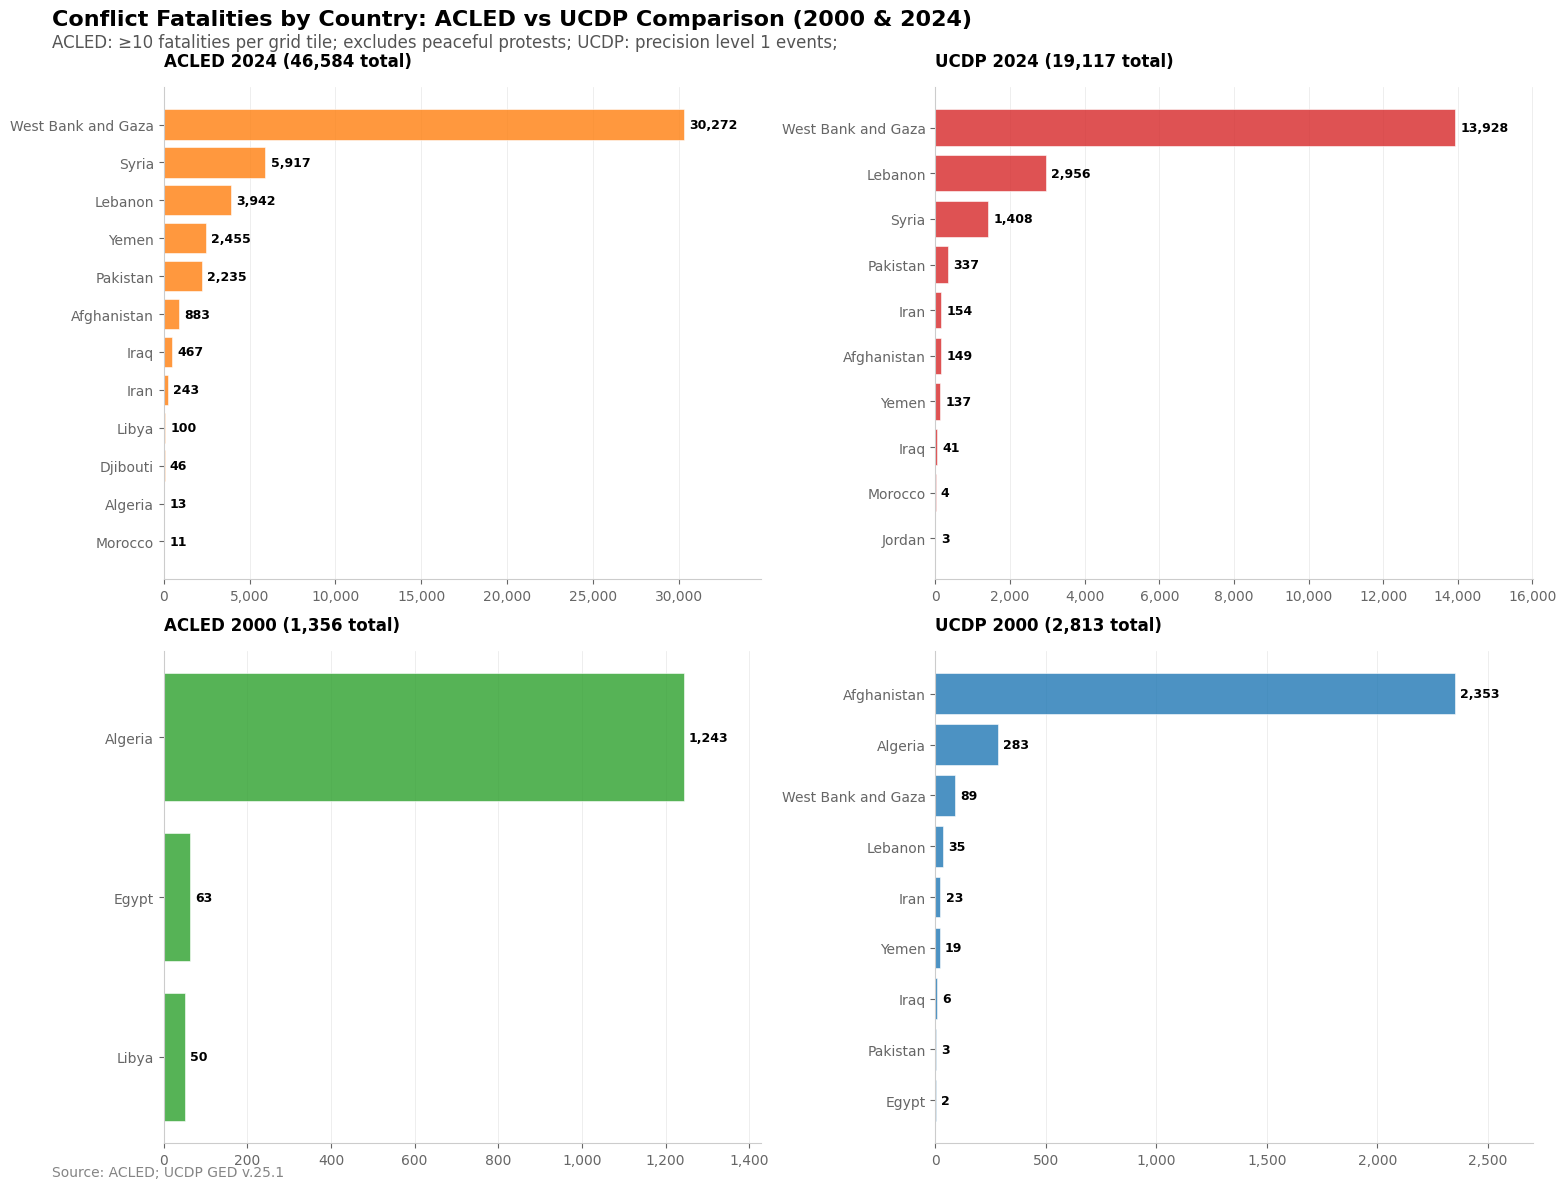

In [35]:
# Country breakdown of fatalities: ACLED vs UCDP for 2000 and 2024
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import numpy as np

# Aggregate fatalities by country for each dataset and year
acled_2000_country = acled_2000_highfat.groupby('country')['fatalities'].sum().sort_values(ascending=True)
acled_2024_country = acled_2024_highfat.groupby('country')['fatalities'].sum().sort_values(ascending=True)
ucdp_2000_country = ucdp_2000.groupby('country')['best'].sum().sort_values(ascending=True)
ucdp_2024_country = ucdp_2024.groupby('country')['best'].sum().sort_values(ascending=True)

# Create subplot with 4 plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.style.use('default')
fig.patch.set_facecolor('white')

# Define colors matching conflict_visuals.py style
colors = ['#ff7f0e', '#d62728', '#2ca02c', '#1f77b4']
datasets = [
    (acled_2024_country, 'ACLED 2024', axes[0, 0], colors[0]),
    (ucdp_2024_country, 'UCDP 2024', axes[0, 1], colors[1]),
    (acled_2000_country, 'ACLED 2000', axes[1, 0], colors[2]),
    (ucdp_2000_country, 'UCDP 2000', axes[1, 1], colors[3])
]

for data_series, title, ax, color in datasets:
    y_pos = np.arange(len(data_series))
    values = data_series.values
    countries = data_series.index
    
    # Calculate total fatalities for this dataset
    total_fatalities = int(values.sum())
    
    # Create horizontal bar chart
    bars = ax.barh(y_pos, values, color=color, alpha=0.8, 
                   edgecolor='white', linewidth=0.5)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        width = bar.get_width()
        pad = 0.01 * (np.nanmax(values) if len(values) else 0)
        if not np.isfinite(pad):
            pad = 0.01
        ax.text(width + pad,
                bar.get_y() + bar.get_height()/2,
                f"{float(value):,.0f}",
                ha='left', va='center', fontsize=9,
                fontweight='bold', color='black')
    
    # Customize subplot with total fatalities in title
    ax.set_yticks(y_pos)
    ax.set_yticklabels(countries, fontsize=10)
    ax.set_xlabel('', fontsize=11, fontweight='bold')
    ax.set_title(f"{title} ({total_fatalities:,} total)", fontsize=12, fontweight='bold', pad=15, loc='left')
    
    # Style the subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.tick_params(colors='#666666')
    ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Set x-axis limits
    vmax = float(np.nanmax(values)) if len(values) else 0.0
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = 1.0
    ax.set_xlim(0, vmax * 1.15)
    
    # X-axis formatter
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Add overall title
fig.suptitle('Conflict Fatalities by Country: ACLED vs UCDP Comparison (2000 & 2024)', 
             fontsize=16, fontweight='bold', y=0.995, ha='left', x=0.05)

# Add subtitle
chart_subtitle = 'ACLED: ≥10 fatalities per grid tile; excludes peaceful protests; UCDP: precision level 1 events; '
fig.text(0.05, 0.975, chart_subtitle, ha='left', va='top', fontsize=12, color='#555555')

# Add source text
source_text = f'Source: ACLED; UCDP GED v.25.1'
fig.text(0.05, 0.02, source_text, ha='left', va='bottom', fontsize=10, 
         color='#666666', alpha=0.8)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.12, top=0.93, bottom=0.05)

plt.savefig('../../results/fatalities_country_breakdown_acled_ucdp_2000_2024.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
pop = gpd.read_file('../../data/population/polygons/MENAAP_pop_quad12.gpkg')
#pop_quad13 = gpd.read_file('../../data/population/polygons/MENAAP_pop_quad13.gpkg')
pop.rename(columns={'country':'country_code'}, inplace=True)
pop = pop[~(pop['country_code'].isin(['SOM', 'SDN', 'MRT']))]

In [37]:
pop[pop['index'].isin(acled_2024_highfat['index'].unique())]['population'].sum()/1000000

np.float64(36.027781111366274)

In [38]:
pop[pop['index'].isin(ucdp_2024['index'].unique())]['population'].sum()/1000000

np.float64(34.14951033633137)

In [39]:
highfat_ucdp_acled = pd.DataFrame(ucdp_2000['index'].unique().tolist() + acled_2000_highfat['index'].unique().tolist())
highfat_ucdp_acled.rename(columns={0:'index'}, inplace=True)

# Helper function to convert quadkey to polygon geometry
import mercantile
from shapely.geometry import box

def quadkey_to_bounds(quadkey, as_polygon=False):
    """Return bounds for a Bing quadkey as a shapely Polygon."""
    t = mercantile.quadkey_to_tile(str(quadkey))
    b = mercantile.bounds(t)
    if as_polygon:
        return box(b.west, b.south, b.east, b.north)
    return (b.west, b.south, b.east, b.north)

highfat_ucdp_acled['geometry'] = highfat_ucdp_acled['index'].apply(lambda x: quadkey_to_bounds(x, as_polygon=True))

In [40]:
highfat_ucdp_acled = gpd.GeoDataFrame(highfat_ucdp_acled, geometry='geometry', crs='EPSG:4326')
highfat_ucdp_acled.to_file('../../data/boundaries/mea_highfat_ucdp_acled_2000.gpkg')

## Population Exposed Summary 2024 (using 2020 WorldPop data)

In [41]:
pop_highfat_ucdp_acled_2000 = pd.read_csv('../../data/ucdp/pop_highfat_ucdp_acled_2000.csv', dtype={'index': str})

In [42]:
pop_acled_2024 = pop[pop['index'].isin(acled_2024_highfat['index'].unique())]
pop_acled_2024 = pop_acled_2024.groupby('country_code')['population'].sum().reset_index()

pop_ucdp_2024 = pop[pop['index'].isin(ucdp_2024['index'].unique())]
pop_ucdp_2024 = pop_ucdp_2024.groupby('country_code')['population'].sum().reset_index()

In [43]:
pop_acled_2000 = pop_highfat_ucdp_acled_2000[pop_highfat_ucdp_acled_2000['index'].isin(acled_2000_highfat['index'].unique())]
pop_acled_2000 = pop_acled_2000.groupby('country_code')['population'].sum().reset_index()

pop_ucdp_2000 = pop_highfat_ucdp_acled_2000[pop_highfat_ucdp_acled_2000['index'].isin(ucdp_2000['index'].unique())]
pop_ucdp_2000 = pop_ucdp_2000.groupby('country_code')['population'].sum().reset_index()

In [44]:
pop_2024 = pop_acled_2024.merge(pop_ucdp_2024, on='country_code', suffixes=('_acled_2024', '_ucdp_2024'), how='outer')
pop_2000 = pop_acled_2000.merge(pop_ucdp_2000, on='country_code', suffixes=('_acled_2000', '_ucdp_2000'), how='outer')

In [45]:
pop_affected = pop_2024.merge(pop_2000, on='country_code', suffixes=('_2024', '_2000'), how='outer')
pop_affected['country'] = pop_affected['country_code'].map(country_code_mapping)
pop_affected['country'].nunique()

15

In [46]:
pop_affected.replace({np.nan:0}, inplace=True)

## Population Exposed Comparison by Country

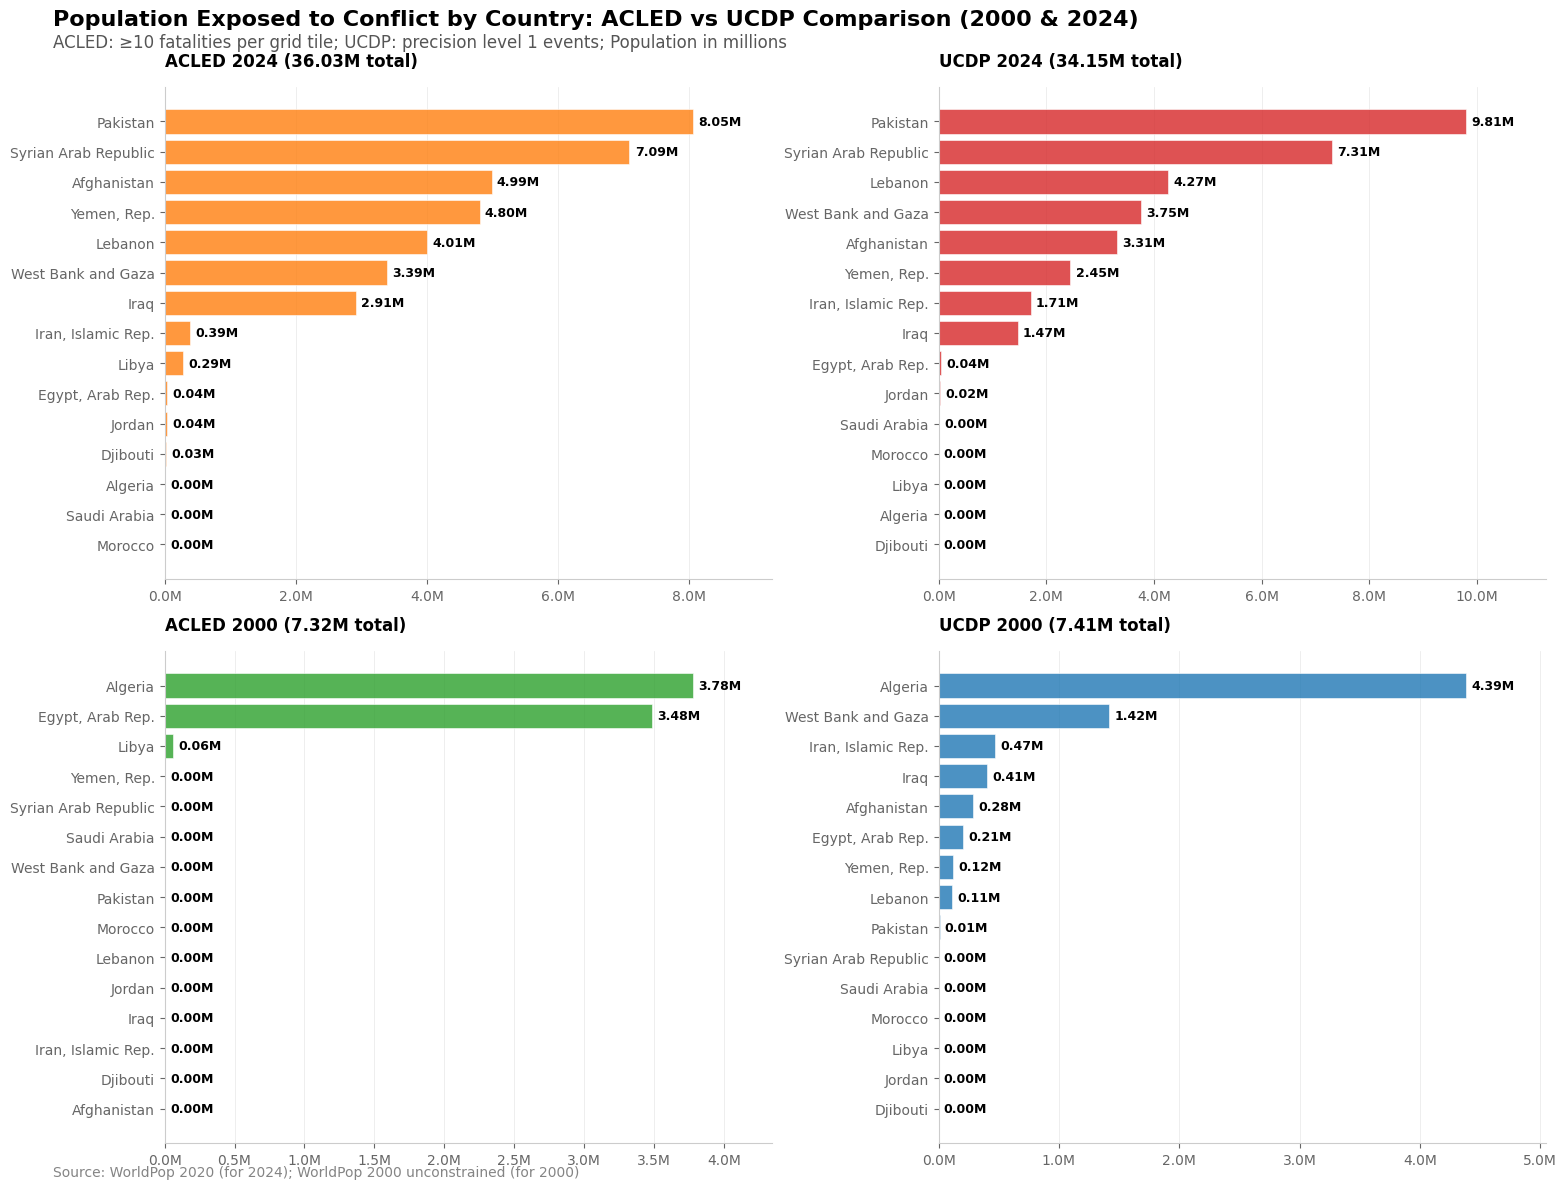

In [47]:
# Population exposed comparison: ACLED vs UCDP for 2000 and 2024
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import numpy as np

# Prepare data - convert to millions and sort
pop_plot = pop_affected.copy()
pop_plot['pop_acled_2024_m'] = pop_plot['population_acled_2024'] / 1_000_000
pop_plot['pop_ucdp_2024_m'] = pop_plot['population_ucdp_2024'] / 1_000_000
pop_plot['pop_acled_2000_m'] = pop_plot['population_acled_2000'] / 1_000_000
pop_plot['pop_ucdp_2000_m'] = pop_plot['population_ucdp_2000'] / 1_000_000

# Sort by ACLED 2024 (descending for better visualization)
acled_2024_sorted = pop_plot.sort_values('pop_acled_2024_m', ascending=True)
acled_2000_sorted = pop_plot.sort_values('pop_acled_2000_m', ascending=True)
ucdp_2024_sorted = pop_plot.sort_values('pop_ucdp_2024_m', ascending=True)
ucdp_2000_sorted = pop_plot.sort_values('pop_ucdp_2000_m', ascending=True)

# Create subplot with 4 plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.style.use('default')
fig.patch.set_facecolor('white')

# Define colors matching conflict_visuals.py style
colors = ['#ff7f0e', '#d62728', '#2ca02c', '#1f77b4']
datasets = [
    (acled_2024_sorted, 'pop_acled_2024_m', 'ACLED 2024', axes[0, 0], colors[0]),
    (ucdp_2024_sorted, 'pop_ucdp_2024_m', 'UCDP 2024', axes[0, 1], colors[1]),
    (acled_2000_sorted, 'pop_acled_2000_m', 'ACLED 2000', axes[1, 0], colors[2]),
    (ucdp_2000_sorted, 'pop_ucdp_2000_m', 'UCDP 2000', axes[1, 1], colors[3])
]

for data_df, metric_col, title, ax, color in datasets:
    y_pos = np.arange(len(data_df))
    values = data_df[metric_col].values
    countries = data_df['country'].values
    
    # Calculate total population for this dataset
    total_pop = values.sum()
    
    # Create horizontal bar chart
    bars = ax.barh(y_pos, values, color=color, alpha=0.8, 
                   edgecolor='white', linewidth=0.5)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        width = bar.get_width()
        pad = 0.01 * (np.nanmax(values) if len(values) else 0)
        if not np.isfinite(pad):
            pad = 0.01
        ax.text(width + pad,
                bar.get_y() + bar.get_height()/2,
                f"{float(value):.2f}M",
                ha='left', va='center', fontsize=9,
                fontweight='bold', color='black')
    
    # Customize subplot with total population in title
    ax.set_yticks(y_pos)
    ax.set_yticklabels(countries, fontsize=10)
    ax.set_xlabel('', fontsize=11, fontweight='bold')
    ax.set_title(f"{title} ({total_pop:.2f}M total)", fontsize=12, fontweight='bold', pad=15, loc='left')
    
    # Style the subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.tick_params(colors='#666666')
    ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Set x-axis limits
    vmax = float(np.nanmax(values)) if len(values) else 0.0
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = 1.0
    ax.set_xlim(0, vmax * 1.15)
    
    # X-axis formatter (already in millions)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}M'))

# Add overall title
fig.suptitle('Population Exposed to Conflict by Country: ACLED vs UCDP Comparison (2000 & 2024)', 
             fontsize=16, fontweight='bold', y=0.995, ha='left', x=0.05)

# Add subtitle
chart_subtitle = 'ACLED: ≥10 fatalities per grid tile; UCDP: precision level 1 events; Population in millions'
fig.text(0.05, 0.975, chart_subtitle, ha='left', va='top', fontsize=12, color='#555555')

# Add source text
source_text = 'Source: WorldPop 2020 (for 2024); WorldPop 2000 unconstrained (for 2000)'
fig.text(0.05, 0.02, source_text, ha='left', va='bottom', fontsize=10, 
         color='#666666', alpha=0.8)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.12, top=0.93, bottom=0.05)

plt.savefig('../../results/population_exposed_country_breakdown_acled_ucdp_2000_2024.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
ucdp['index'] = ucdp.apply(lambda x: get_quadkey_from_lat_lon(x['latitude'], x['longitude'], zoom=12), axis=1)

In [109]:
ucdp_headlines_2000 = mena_ucdp_prec[(mena_ucdp_prec['index'].isin(ucdp_2000['index']))]
ucdp_headlines_2000 = ucdp_headlines_2000[ucdp_headlines_2000['year']==2000][ 'source_article']

ucdp_headlines_2024 = mena_ucdp_prec[(mena_ucdp_prec['index'].isin(ucdp_2024['index']))]
ucdp_headlines_2024 = ucdp_headlines_2024[ucdp_headlines_2024['year']==2024][ 'source_article']

In [110]:
acled_headlines_2000 = data[data['index'].isin(acled_2000_highfat['index'])]
acled_headlines_2000 = acled_headlines_2000[acled_headlines_2000['event_date'].dt.year==2000]

acled_headlines_2024 = data[data['index'].isin(acled_2024_highfat['index'])]
acled_headlines_2024 = acled_headlines_2024[acled_headlines_2024['event_date'].dt.year==2024]

In [ ]:
# Combined Map: Compare UCDP vs ACLED for both 2000 and 2024 with layer controls
import folium

# Get indices for both years
ucdp_2000_indices = set(ucdp_2000['index'].unique())
acled_2000_indices = set(acled_2000_highfat['index'].unique())
ucdp_2024_indices = set(ucdp_2024['index'].unique())
acled_2024_indices = set(acled_2024_highfat['index'].unique())

# Create base map with grey background
base_map = folium.Map(
    location=[30, 45], 
    zoom_start=4, 
    tiles='CartoDB positron'  # Grey background map
)

# --- 2000 Data Layers (using pop_highfat_ucdp_acled_2000 for population) ---
# UCDP only 2000
ucdp_only_2000 = ucdp_2000_indices - acled_2000_indices
if len(ucdp_only_2000) > 0:
    pop_ucdp_only_2000 = pop_highfat_ucdp_acled_2000[pop_highfat_ucdp_acled_2000['index'].isin(ucdp_only_2000)].copy()
    if len(pop_ucdp_only_2000) > 0:
        pop_ucdp_only_2000['source'] = 'UCDP only (2000)'
        # Merge with pop geodataframe to get geometry and with ucdp_2000 to get fatalities
        pop_ucdp_only_2000_geo = pop[pop['index'].isin(ucdp_only_2000)].copy()
        pop_ucdp_only_2000_geo = pop_ucdp_only_2000_geo.merge(
            pop_ucdp_only_2000[['index', 'population']], 
            on='index', 
            how='left',
            suffixes=('_geo', '_2000')
        )
        # Add fatalities from ucdp_2000 (use 'best' column)
        ucdp_2000_fat = ucdp_2000[ucdp_2000['index'].isin(ucdp_only_2000)].groupby('index')['best'].sum().reset_index()
        pop_ucdp_only_2000_geo = pop_ucdp_only_2000_geo.merge(
            ucdp_2000_fat[['index', 'best']], 
            on='index', 
            how='left'
        )
        pop_ucdp_only_2000_geo['source'] = 'UCDP only (2000)'
        folium.GeoJson(
            pop_ucdp_only_2000_geo,
            name='UCDP only 2000',
            style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 1, 'fillOpacity': 0.6},
            tooltip=folium.GeoJsonTooltip(fields=['index', 'country_code', 'population_2000', 'best', 'source'], 
                                          aliases=['Index', 'Country', 'Population (2000)', 'Fatalities', 'Source'])
        ).add_to(base_map)

# ACLED only 2000
acled_only_2000 = acled_2000_indices - ucdp_2000_indices
if len(acled_only_2000) > 0:
    pop_acled_only_2000 = pop_highfat_ucdp_acled_2000[pop_highfat_ucdp_acled_2000['index'].isin(acled_only_2000)].copy()
    if len(pop_acled_only_2000) > 0:
        pop_acled_only_2000['source'] = 'ACLED only (2000)'
        pop_acled_only_2000_geo = pop[pop['index'].isin(acled_only_2000)].copy()
        pop_acled_only_2000_geo = pop_acled_only_2000_geo.merge(
            pop_acled_only_2000[['index', 'population']], 
            on='index', 
            how='left',
            suffixes=('_geo', '_2000')
        )
        # Add fatalities from acled_2000_highfat
        acled_2000_fat = acled_2000_highfat[acled_2000_highfat['index'].isin(acled_only_2000)][['index', 'fatalities']]
        pop_acled_only_2000_geo = pop_acled_only_2000_geo.merge(
            acled_2000_fat, 
            on='index', 
            how='left'
        )
        pop_acled_only_2000_geo['source'] = 'ACLED only (2000)'
        folium.GeoJson(
            pop_acled_only_2000_geo,
            name='ACLED only 2000',
            style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'weight': 1, 'fillOpacity': 0.6},
            tooltip=folium.GeoJsonTooltip(fields=['index', 'country_code', 'population_2000', 'fatalities', 'source'],
                                          aliases=['Index', 'Country', 'Population (2000)', 'Fatalities', 'Source'])
        ).add_to(base_map)

# Both 2000
both_2000 = ucdp_2000_indices & acled_2000_indices
if len(both_2000) > 0:
    pop_both_2000 = pop_highfat_ucdp_acled_2000[pop_highfat_ucdp_acled_2000['index'].isin(both_2000)].copy()
    if len(pop_both_2000) > 0:
        pop_both_2000['source'] = 'Both UCDP & ACLED (2000)'
        pop_both_2000_geo = pop[pop['index'].isin(both_2000)].copy()
        pop_both_2000_geo = pop_both_2000_geo.merge(
            pop_both_2000[['index', 'population']], 
            on='index', 
            how='left',
            suffixes=('_geo', '_2000')
        )
        # Add fatalities from both datasets
        ucdp_2000_fat = ucdp_2000[ucdp_2000['index'].isin(both_2000)].groupby('index')['best'].sum().reset_index()
        ucdp_2000_fat.rename(columns={'best': 'ucdp_fatalities'}, inplace=True)
        acled_2000_fat = acled_2000_highfat[acled_2000_highfat['index'].isin(both_2000)][['index', 'fatalities']]
        acled_2000_fat.rename(columns={'fatalities': 'acled_fatalities'}, inplace=True)
        pop_both_2000_geo = pop_both_2000_geo.merge(ucdp_2000_fat, on='index', how='left')
        pop_both_2000_geo = pop_both_2000_geo.merge(acled_2000_fat, on='index', how='left')
        pop_both_2000_geo['source'] = 'Both UCDP & ACLED (2000)'
        folium.GeoJson(
            pop_both_2000_geo,
            name='Both UCDP & ACLED 2000',
            style_function=lambda x: {'fillColor': 'purple', 'color': 'purple', 'weight': 1, 'fillOpacity': 0.6},
            tooltip=folium.GeoJsonTooltip(fields=['index', 'country_code', 'population_2000', 'ucdp_fatalities', 'acled_fatalities', 'source'],
                                          aliases=['Index', 'Country', 'Population (2000)', 'UCDP Fatalities', 'ACLED Fatalities', 'Source'])
        ).add_to(base_map)

# --- 2024 Data Layers (using pop for population - 2020 data) ---
# UCDP only 2024
ucdp_only_2024 = ucdp_2024_indices - acled_2024_indices
if len(ucdp_only_2024) > 0:
    pop_ucdp_only_2024 = pop[pop['index'].isin(ucdp_only_2024)].copy()
    # Add fatalities from ucdp_2024 (use 'best' column)
    ucdp_2024_fat = ucdp_2024[ucdp_2024['index'].isin(ucdp_only_2024)].groupby('index')['best'].sum().reset_index()
    pop_ucdp_only_2024 = pop_ucdp_only_2024.merge(ucdp_2024_fat[['index', 'best']], on='index', how='left')
    pop_ucdp_only_2024['source'] = 'UCDP only (2024)'
    folium.GeoJson(
        pop_ucdp_only_2024,
        name='UCDP only 2024',
        style_function=lambda x: {'fillColor': 'lightblue', 'color': 'lightblue', 'weight': 1, 'fillOpacity': 0.6},
        tooltip=folium.GeoJsonTooltip(fields=['index', 'country_code', 'population', 'best', 'source'],
                                      aliases=['Index', 'Country', 'Population (2024)', 'Fatalities', 'Source'])
    ).add_to(base_map)

# ACLED only 2024
acled_only_2024 = acled_2024_indices - ucdp_2024_indices
if len(acled_only_2024) > 0:
    pop_acled_only_2024 = pop[pop['index'].isin(acled_only_2024)].copy()
    # Add fatalities from acled_2024_highfat
    acled_2024_fat = acled_2024_highfat[acled_2024_highfat['index'].isin(acled_only_2024)][['index', 'fatalities']]
    pop_acled_only_2024 = pop_acled_only_2024.merge(acled_2024_fat, on='index', how='left')
    pop_acled_only_2024['source'] = 'ACLED only (2024)'
    folium.GeoJson(
        pop_acled_only_2024,
        name='ACLED only 2024',
        style_function=lambda x: {'fillColor': 'orange', 'color': 'orange', 'weight': 1, 'fillOpacity': 0.6},
        tooltip=folium.GeoJsonTooltip(fields=['index', 'country_code', 'population', 'fatalities', 'source'],
                                      aliases=['Index', 'Country', 'Population (2024)', 'Fatalities', 'Source'])
    ).add_to(base_map)

# Both 2024
both_2024 = ucdp_2024_indices & acled_2024_indices
if len(both_2024) > 0:
    pop_both_2024 = pop[pop['index'].isin(both_2024)].copy()
    # Add fatalities from both datasets
    ucdp_2024_fat = ucdp_2024[ucdp_2024['index'].isin(both_2024)].groupby('index')['best'].sum().reset_index()
    ucdp_2024_fat.rename(columns={'best': 'ucdp_fatalities'}, inplace=True)
    acled_2024_fat = acled_2024_highfat[acled_2024_highfat['index'].isin(both_2024)][['index', 'fatalities']]
    acled_2024_fat.rename(columns={'fatalities': 'acled_fatalities'}, inplace=True)
    pop_both_2024 = pop_both_2024.merge(ucdp_2024_fat, on='index', how='left')
    pop_both_2024 = pop_both_2024.merge(acled_2024_fat, on='index', how='left')
    pop_both_2024['source'] = 'Both UCDP & ACLED (2024)'
    folium.GeoJson(
        pop_both_2024,
        name='Both UCDP & ACLED 2024',
        style_function=lambda x: {'fillColor': 'magenta', 'color': 'magenta', 'weight': 1, 'fillOpacity': 0.6},
        tooltip=folium.GeoJsonTooltip(fields=['index', 'country_code', 'population', 'ucdp_fatalities', 'acled_fatalities', 'source'],
                                      aliases=['Index', 'Country', 'Population (2024)', 'UCDP Fatalities', 'ACLED Fatalities', 'Source'])
    ).add_to(base_map)

# Add layer control to toggle layers on/off
folium.LayerControl(collapsed=False).add_to(base_map)

# Save the map
base_map.save('../../results/conflict_comparison_2000_2024_layered.html')

# Print summary statistics
print("=" * 60)
print("2000 Comparison:")
print(f"  UCDP only: {len(ucdp_only_2000)}, ACLED only: {len(acled_only_2000)}, Both: {len(both_2000)}")
print(f"  Total unique grids: {len(ucdp_2000_indices | acled_2000_indices)}")
print("\n2024 Comparison:")
print(f"  UCDP only: {len(ucdp_only_2024)}, ACLED only: {len(acled_only_2024)}, Both: {len(both_2024)}")
print(f"  Total unique grids: {len(ucdp_2024_indices | acled_2024_indices)}")
print("=" * 60)

base_map

2000 Comparison:
  UCDP only: 118, ACLED only: 23, Both: 13
  Total unique grids: 154

2024 Comparison:
  UCDP only: 262, ACLED only: 253, Both: 237
  Total unique grids: 752


### Spatial Proximity of Grids from ACLED and UCDP

In [127]:
# Analyze spatial proximity of UCDP and ACLED grids in 2024
# Categorize distance into buckets: same grid, 1 grid away, 2 grids away, 3+ grids away
import mercantile
from collections import defaultdict

def get_neighbors_by_distance(quadkey, max_distance=3):
    """Get neighbors at each distance (1, 2, 3) from the given quadkey.
    Returns dict with distance as key and set of quadkeys as value."""
    tile = mercantile.quadkey_to_tile(quadkey)
    x, y, z = tile.x, tile.y, tile.z
    
    neighbors_by_dist = {}
    for dist in range(1, max_distance + 1):
        neighbors = set()
        for dx in range(-dist, dist + 1):
            for dy in range(-dist, dist + 1):
                if abs(dx) == dist or abs(dy) == dist:  # Only tiles at exactly this distance
                    neighbor_tile = mercantile.Tile(x + dx, y + dy, z)
                    try:
                        neighbors.add(mercantile.quadkey(neighbor_tile))
                    except:
                        pass  # Out of bounds
        neighbors_by_dist[dist] = neighbors
    return neighbors_by_dist

def find_min_distance(quadkey, target_set, max_check=3):
    """Find minimum distance from quadkey to any grid in target_set.
    Returns 0 if same grid, 1-3 for distance, 4+ for beyond max_check."""
    if quadkey in target_set:
        return 0
    
    neighbors = get_neighbors_by_distance(quadkey, max_distance=max_check)
    for dist in range(1, max_check + 1):
        if neighbors[dist] & target_set:
            return dist
    return max_check + 1  # 3+ grids away

# Get UCDP and ACLED grid sets for 2024
ucdp_2024_set = set(ucdp_2024['index'].unique())
acled_2024_set = set(acled_2024_highfat['index'].unique())

# Separate into only-UCDP and only-ACLED
ucdp_only_2024_set = ucdp_2024_set - acled_2024_set
acled_only_2024_set = acled_2024_set - ucdp_2024_set
both_2024_set = ucdp_2024_set & acled_2024_set

print("Analyzing spatial proximity of UCDP and ACLED grids in 2024...")
print(f"UCDP-only grids: {len(ucdp_only_2024_set)}")
print(f"ACLED-only grids: {len(acled_only_2024_set)}")
print(f"Overlapping grids (both): {len(both_2024_set)}")

# Distance distribution from UCDP-only to nearest ACLED-only
ucdp_distance_counts = defaultdict(int)
print("\nAnalyzing UCDP-only grids...")
for quadkey in ucdp_only_2024_set:
    min_dist = find_min_distance(quadkey, acled_only_2024_set, max_check=3)
    ucdp_distance_counts[min_dist] += 1

# Distance distribution from ACLED-only to nearest UCDP-only
acled_distance_counts = defaultdict(int)
print("Analyzing ACLED-only grids...")
for quadkey in acled_only_2024_set:
    min_dist = find_min_distance(quadkey, ucdp_only_2024_set, max_check=3)
    acled_distance_counts[min_dist] += 1

# Print results
print("\n" + "=" * 70)
print("SPATIAL PROXIMITY ANALYSIS - DISTANCE DISTRIBUTION (2024)")
print("=" * 70)

print("\nUCDP-only grids - Distance to nearest ACLED-only grid:")
print("-" * 70)
distance_labels = {1: "1 grid away (adjacent)", 2: "2 grids away", 3: "3 grids away", 4: "3+ grids away"}
total_ucdp = len(ucdp_only_2024_set)
for dist in [1, 2, 3, 4]:
    count = ucdp_distance_counts[dist]
    pct = (count / total_ucdp * 100) if total_ucdp > 0 else 0
    label = distance_labels[dist]
    print(f"  {label:25s}: {count:4d} grids ({pct:5.1f}%)")

print("\nACLED-only grids - Distance to nearest UCDP-only grid:")
print("-" * 70)
total_acled = len(acled_only_2024_set)
for dist in [1, 2, 3, 4]:
    count = acled_distance_counts[dist]
    pct = (count / total_acled * 100) if total_acled > 0 else 0
    label = distance_labels[dist]
    print(f"  {label:25s}: {count:4d} grids ({pct:5.1f}%)")

# Summary statistics
ucdp_within_2 = sum(ucdp_distance_counts[d] for d in [1, 2])
acled_within_2 = sum(acled_distance_counts[d] for d in [1, 2])
pct_ucdp_within_2 = (ucdp_within_2 / total_ucdp * 100) if total_ucdp > 0 else 0
pct_acled_within_2 = (acled_within_2 / total_acled * 100) if total_acled > 0 else 0

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"UCDP-only grids within 2 tiles of ACLED: {ucdp_within_2}/{total_ucdp} ({pct_ucdp_within_2:.1f}%)")
print(f"ACLED-only grids within 2 tiles of UCDP: {acled_within_2}/{total_acled} ({pct_acled_within_2:.1f}%)")

Analyzing spatial proximity of UCDP and ACLED grids in 2024...
UCDP-only grids: 262
ACLED-only grids: 253
Overlapping grids (both): 237

Analyzing UCDP-only grids...
Analyzing ACLED-only grids...

SPATIAL PROXIMITY ANALYSIS - DISTANCE DISTRIBUTION (2024)

UCDP-only grids - Distance to nearest ACLED-only grid:
----------------------------------------------------------------------
  1 grid away (adjacent)   :   95 grids ( 36.3%)
  2 grids away             :   56 grids ( 21.4%)
  3 grids away             :   30 grids ( 11.5%)
  3+ grids away            :   81 grids ( 30.9%)

ACLED-only grids - Distance to nearest UCDP-only grid:
----------------------------------------------------------------------
  1 grid away (adjacent)   :   79 grids ( 31.2%)
  2 grids away             :   44 grids ( 17.4%)
  3 grids away             :   26 grids ( 10.3%)
  3+ grids away            :  104 grids ( 41.1%)

SUMMARY
UCDP-only grids within 2 tiles of ACLED: 151/262 (57.6%)
ACLED-only grids within 2 tiles o

### Event similarity between ACLED and UCDP

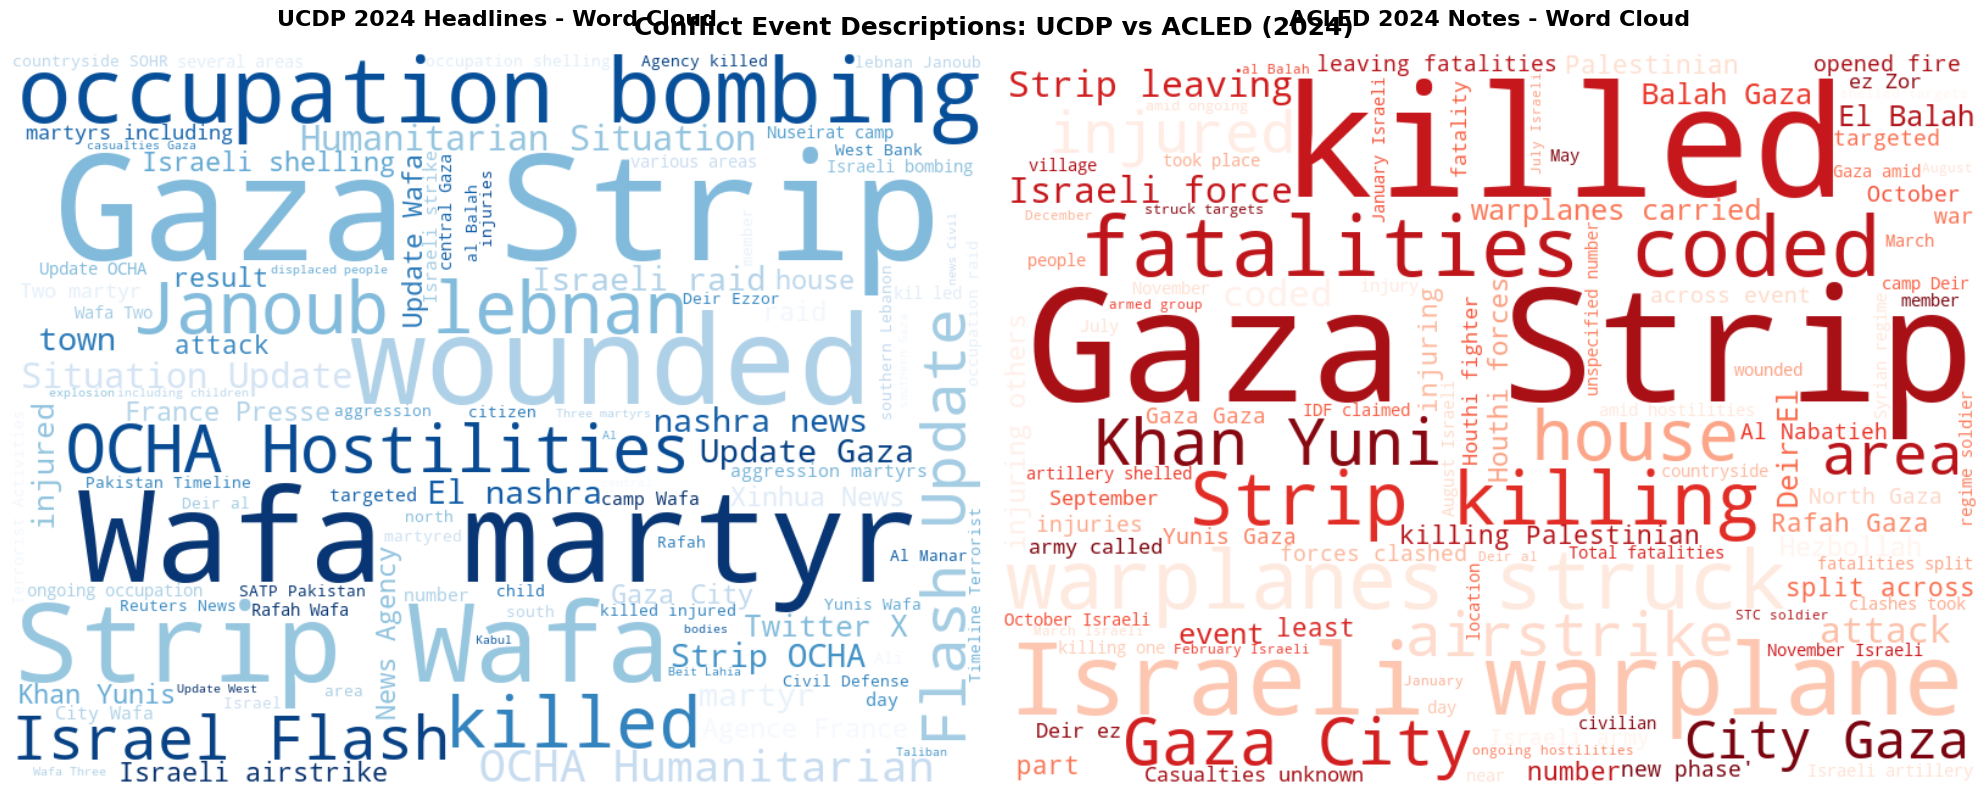

UCDP 2024: 4332 headlines
ACLED 2024: 10241 event notes


In [124]:
# Create word clouds from UCDP and ACLED headlines for 2024
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all UCDP headlines into one text
ucdp_text = ' '.join(ucdp_headlines_2024.dropna().astype(str).tolist())

# Combine all ACLED notes/headlines into one text
acled_text = ' '.join(acled_headlines_2024.astype(str).tolist())

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor('white')

# UCDP Word Cloud
wordcloud_ucdp = WordCloud(
    width=800, 
    height=600, 
    background_color='white',
    colormap='Blues',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(ucdp_text)

axes[0].imshow(wordcloud_ucdp, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('UCDP 2024 Headlines - Word Cloud', fontsize=16, fontweight='bold', pad=20)

# ACLED Word Cloud
wordcloud_acled = WordCloud(
    width=800, 
    height=600, 
    background_color='white',
    colormap='Reds',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(acled_text)

axes[1].imshow(wordcloud_acled, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('ACLED 2024 Notes - Word Cloud', fontsize=16, fontweight='bold', pad=20)

# Add overall title
fig.suptitle('Conflict Event Descriptions: UCDP vs ACLED (2024)', 
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('../../results/wordcloud_comparison_ucdp_acled_2024.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"UCDP 2024: {len(ucdp_headlines_2024)} headlines")
print(f"ACLED 2024: {len(acled_headlines_2024)} event notes")

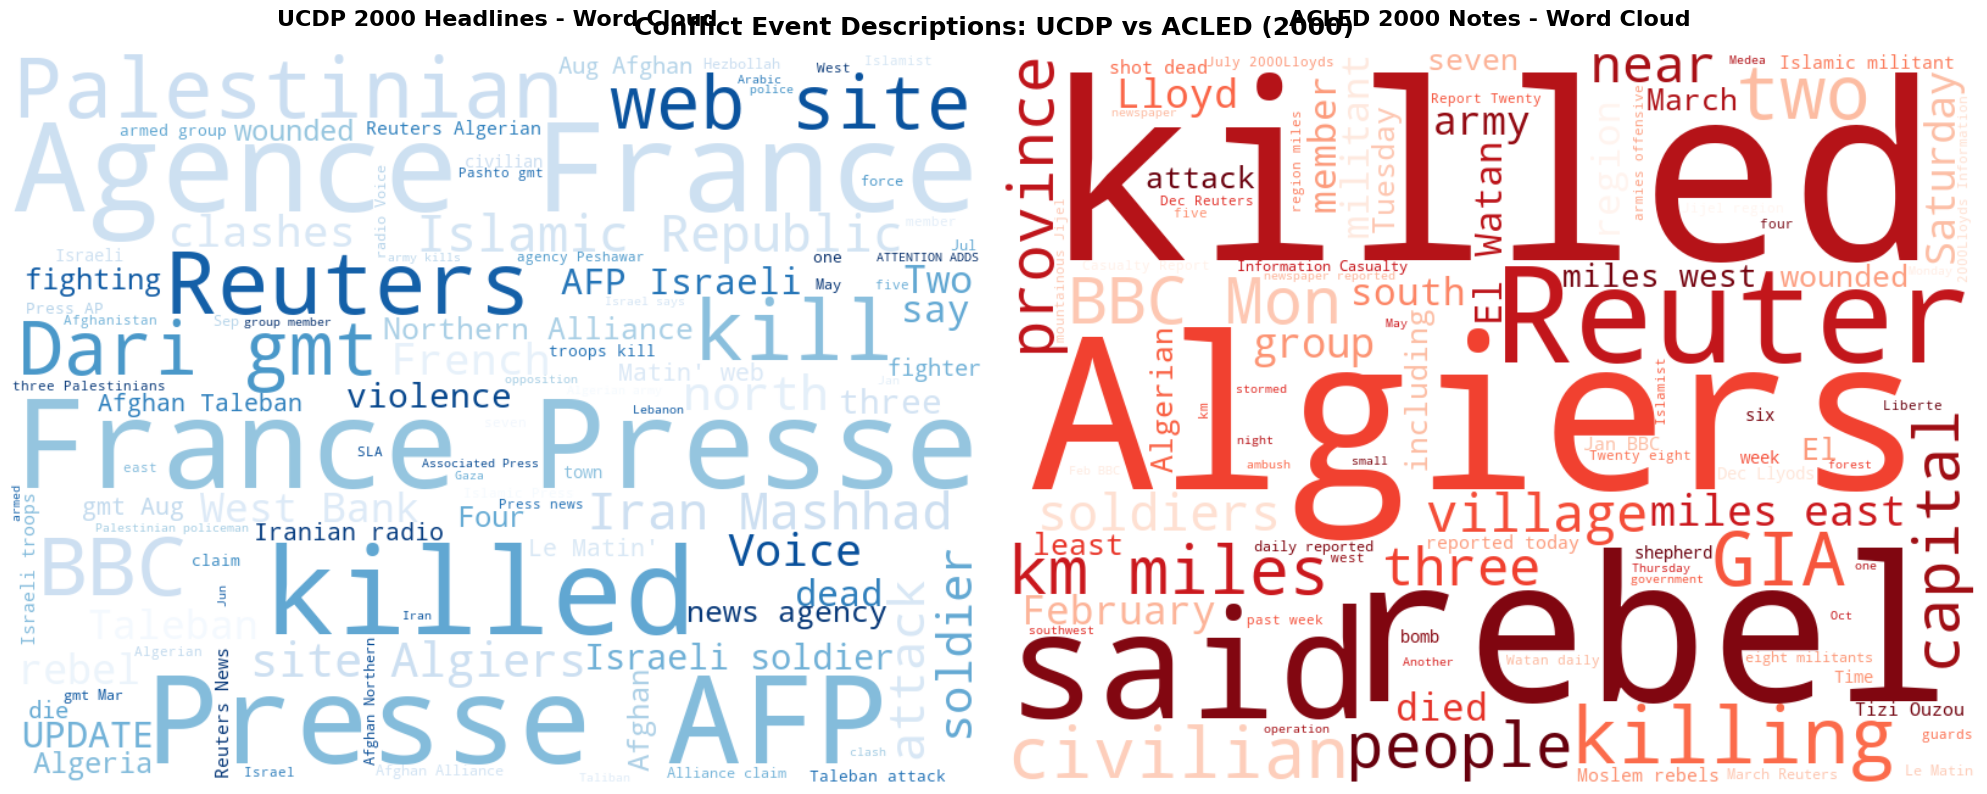

UCDP 2000: 218 headlines
ACLED 2000: 133 event notes


In [126]:
# Create word clouds from UCDP and ACLED headlines for 2000
from wordcloud import WordCloud
import matplotlib.pyplot as plt

acled_headlines_2000 = acled_headlines_2000['notes']
# Combine all UCDP headlines into one text for 2000
ucdp_text_2000 = ' '.join(ucdp_headlines_2000.dropna().astype(str).tolist())

# Combine all ACLED notes/headlines into one text for 2000
acled_text_2000 = ' '.join(acled_headlines_2000.astype(str).tolist())

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor('white')

# UCDP Word Cloud
wordcloud_ucdp_2000 = WordCloud(
    width=800, 
    height=600, 
    background_color='white',
    colormap='Blues',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(ucdp_text_2000)

axes[0].imshow(wordcloud_ucdp_2000, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('UCDP 2000 Headlines - Word Cloud', fontsize=16, fontweight='bold', pad=20)

# ACLED Word Cloud
wordcloud_acled_2000 = WordCloud(
    width=800, 
    height=600, 
    background_color='white',
    colormap='Reds',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(acled_text_2000)

axes[1].imshow(wordcloud_acled_2000, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('ACLED 2000 Notes - Word Cloud', fontsize=16, fontweight='bold', pad=20)

# Add overall title
fig.suptitle('Conflict Event Descriptions: UCDP vs ACLED (2000)', 
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('../../results/wordcloud_comparison_ucdp_acled_2000.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"UCDP 2000: {len(ucdp_headlines_2000)} headlines")
print(f"ACLED 2000: {len(acled_headlines_2000)} event notes")